# Simulation 3X

In this notebook we run a few sensitivity studies starting from the results in *Simulation3.ipynb*.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has 4 ports, 5 potential vulnerable webservices it may be running, 4 potential vulnerable parameter it may receive at 2 different levels of depth.

This implies 45 possible concrete actions for the attacker.

Setting a random seed

In [2]:
np.random.seed(0)

### Random server
We define a simple function to instantiate random servers.

In [3]:
def random_server():
    vulnport = np.random.randint(0,const.N_PORTS)
    vulntype = np.random.choice(const.VULNTYPES)
    
    if(vulntype==const.VULNTYPE_ACCESSPOINT):
        vulnlevel = const.VULNLEVEL_NONE
        n = np.argmax(np.random.multinomial(1,[.5,.3,.1,.05,.05]))+1
        vulnvalue = np.random.choice(const.ACCESSPOINTS,n,replace=False)
    elif(vulntype==const.VULNTYPE_PARAM):
        vulnlevel = np.random.choice(const.VULNLEVELS)
        vulnvalue = np.random.randint(1,const.N_VULNPARAMS+1)
        
    return srv.Server(vulnport, vulnlevel, vulntype, vulnvalue)

## Simulation 3X
We run the previous simulation for $20$ times in order to collect stable statistics.

**(Notice that this may take MANY minutes to run)**

In [4]:
epsilons = [.1,.5,.9]

ntrials = 20
nepisodes = 10**5

steps = np.zeros((len(epsilons),ntrials,nepisodes))
rewards = np.zeros((len(epsilons),ntrials,nepisodes))
Qlens = np.zeros((len(epsilons),ntrials,nepisodes))

for i in range(len(epsilons)):

    for t in tqdm(range(ntrials)):

        agt = agn.Agent(verbose=False)
        agt.set_learning_options(exploration=epsilons[i], 
                             learningrate=0.1, 
                             discount=0.9)

        for e in range(nepisodes):
            env = random_server()
            agt.reset(env)

            agt.run_episode()

            steps[i,t,e] = agt.steps
            rewards[i,t,e] = agt.rewards
            Qlens[i,t,e] = len(agt.Q)
    

100%|███████████████████████████████████████████| 20/20 [10:05<00:00, 30.29s/it]


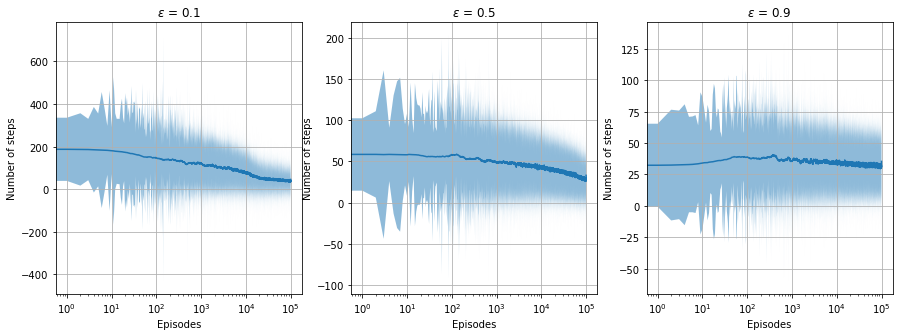

In [9]:
plt.figure(figsize=(15,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes)
    y = np.mean(uniform_filter1d(steps[i,:,:],size=100,mode='nearest'),axis=0)
    ystd = np.std(steps[i,:,:],axis=0)

    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
    
    plt.xscale('log')
    #plt.ylim(0,200)
    plt.xlabel('Episodes')
    plt.ylabel('Number of steps')
    plt.title('$\epsilon$ = {0}'.format(epsilons[i]))
    plt.grid()
    
plt.savefig('simul3_epsilon_steps.png',dpi=300)

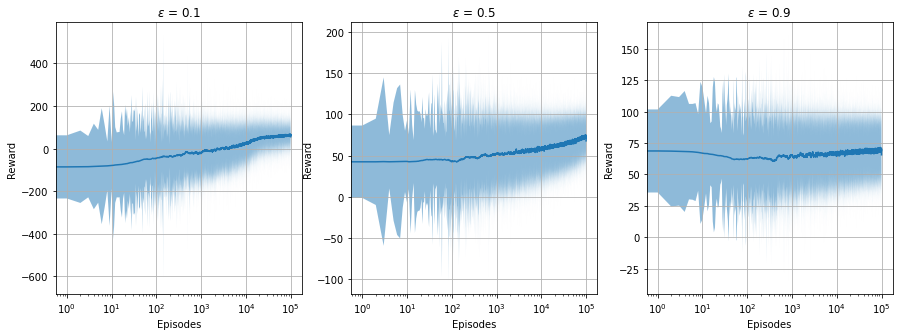

In [10]:
plt.figure(figsize=(15,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes)
    y = np.mean(uniform_filter1d(rewards[i,:,:],size=100,mode='nearest'),axis=0)
    ystd = np.std(rewards[i,:,:],axis=0)

    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

    plt.xscale('log')
    #plt.ylim(-50,150)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('$\epsilon$ = {0}'.format(epsilons[i]))
    plt.grid()
    
plt.savefig('simul3_epsilon_rewards.png',dpi=300)

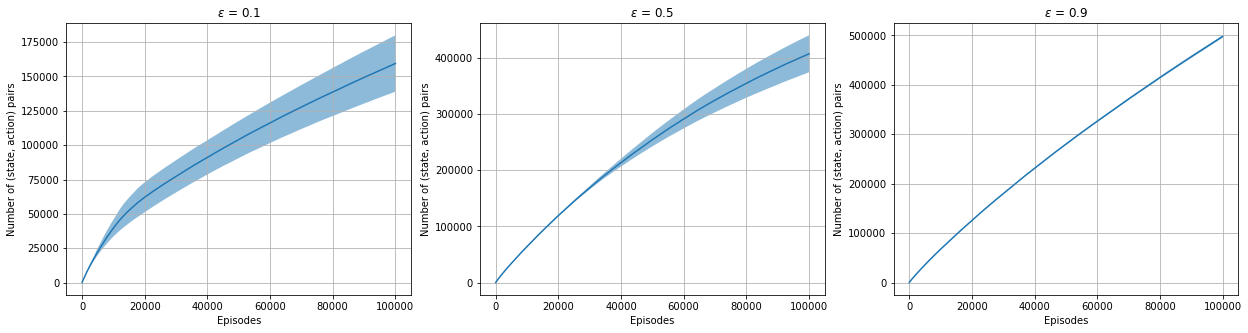

In [11]:
plt.figure(figsize=(21,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes)
    y = np.mean(uniform_filter1d(Qlens[i,:,:],size=100,mode='nearest'),axis=0)
    ystd = np.std(Qlens[i,:,:],axis=0)

    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

    plt.xlabel('Episodes')
    plt.ylabel('Number of (state, action) pairs')
    plt.title('$\epsilon$ = {0}'.format(epsilons[i]))
    plt.grid()
    
plt.savefig('simul3_epsilon_qlens.png',dpi=300)